# Prediction Study on the Factors Associated with Total Violent Crime Numbers in California

#### Group member:&nbsp;&nbsp; Emily Ahn &nbsp; &nbsp; Xiaoran Fan &nbsp; &nbsp; Vicky Lin &nbsp; &nbsp; Chunyu Zhang      

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(infer)
library(cowplot)
library(GGally)
library(broom)
library(dplyr)
library(AER)
library(digest)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(faraway)
library(mltools)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


Attaching package: ‘gridExtra’


The following obj

## Introduction

Nowadays, crime has become a severe problem around the world and is increasing in our society, making people feel anxious and unsafe all the time. Research showed many young people from US and Canadian colleges expressed being fearful of crime on and off campus (Leah E Daigle et al, 2021), which arises people’s thinking on the factors related to crime commission. According to National Research Council (2008), factors such as the state of economic opportunity, demographic groups and etc. may have a relationship with crime. Therefore, we decided to use the Communities and Crime Data Set acquired from UCI Machine Learning Repository by Michael Redmond to examine the predictive question: **For one specific state in US, California, among the factors of population density, young age rate, urbanization, income, poverty, education, unemployment, divorce rate and the number of people in a family, what variables can build up the best model to predict the total crime number?**
 
 
Our data set includes real data from socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. This dataset contains a total number of 128 attributes and 1994 instances. In our study, we will focus on one specific state in US, California, therefore we will use 278 instances of the data (which are instances of California). Moreover, according to Uniform Crime Report from FBI, we learnt that some potential variables such as income rate, poverty level and etc. may affect crime rate, therefore, we will not use all of the variables in the dataset but chose 11 variables based on the Uniform Crime Report to study (10 explanatory variables and 1 response variable). In this study, our focus is predictive, and we will use the linear regression and LASSO models to do the prediction study.

## Methods and Results

### Preliminary Results

#### Load Data

We first read the `communities.data` in data file and named it `crime_data`. 

In [2]:
set.seed(4)
crime_data <- read_csv("data/communities.data", col_names = FALSE)

head(crime_data)

Rows: 1994 Columns: 128
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): X2, X3, X4, X31, X102, X103, X104, X105, X106, X107, X108, X109, ...
dbl (102): X1, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1 X2 X3    X4                  X5 X6   X7   X8   X9   X10  ⋯ X119 X120 X121
1  8 ?  ?     Lakewoodcity        1  0.19 0.33 0.02 0.90 0.12 ⋯ 0.12 0.26 0.20
2 53 ?  ?     Tukwilacity         1  0.00 0.16 0.12 0.74 0.45 ⋯ 0.02 0.12 0.45
3 24 ?  ?     Aberdeentown        1  0.00 0.42 0.49 0.56 0.17 ⋯ 0.01 0.21 0.02
4 34 5  81440 Willingborotownship 1  0.04 0.77 1.00 0.08 0.12 ⋯ 0.02 0.39 0.28
5 42 95 6096  Bethlehemtownship   1  0.01 0.55 0.02 0.95 0.09 ⋯ 0.04 0.09 0.02
6  6 ?  ?     SouthPasadenacity   1  0.02 0.28 0.06 0.54 1.00 ⋯ 0.01 0.58 0.10
  X122 X123 X124 X125 X126 X127 X128
1 0.06 0.04 0.9  0.5  0.32 0.14 0.20
2 ?    ?    ?    ?    0.00 ?    0.67
3 ?    ?    ?    ?    0.00 ?    0.43
4 ?    ?    ?    ?    0.00 ?    0.12
5 ?    ?    ?    ?    0.00 ?    0.03
6 ?    ?    ?    ?    0.00 ?    0.14

*Table 1.1 Raw dataset*

#### Clean and Wrangle Data

We find that, in some of the variables, not all of the values are completely collected, so we select the variables with no missed data.

Then we add the descripitions of each data we selected according to the `communities.names` file as follow:

- X1 -- `state`: US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal)

- X6 -- `popComm`: population for community: (numeric - decimal)

- X14 -- `agePct16t24`: percentage of population that is 16-24 in age (numeric - decimal)

- X17 -- `pctUrban`: percentage of people living in areas classified as urban (numeric - decimal)<br>
      (In this variable, we are interested in whether or not there is people living in areas classified as urban, so we decide to change the datatype of this variable to categorical variable. We decide to classify the data with a percentage of 0 as `non-urban`, which means that *no one lives in an urban area*, and we classified the data with a percentage larger than 0 as `urban`, which means that *there are people living in cities*.)

- X26 -- `perCapInc`: per capita income (numeric - decimal)

- X34 -- `pctUnderPov`: percentage of people under the poverty level (numeric - decimal)

- X36 -- `pctNotHSGrad`: percentage of people 25 and over that are not high school graduates (numeric - decimal)

- X38 -- `pctUnemployed`: percentage of people 16 and over, in the labor force, and unemployed (numeric - decimal)

- X47 -- `pctDiv`: percentage of population who are divorced (numeric - decimal)

- X48 -- `meanPerFam`: mean number of people per family (numeric - decimal)

- X128 -- `totCrimesPerPop`: total number of violent crimes per 100K popuation (numeric - decimal) GOAL attribute (to be predicted)

We call the new dataset `crime` and print the first and last 6 rows in the `crime`.

We also count the total number of row in `crime` and assume it as the population of our research.

In [3]:
crime <- crime_data %>%
  select(X1,X6,X14,X17,X26,X34,X36,X38,X47,X48,X128)%>%
  rename(state = X1,
         popComm = X6,
         agePct16t24 = X14,
         pctUrban = X17,
         perCapInc = X26,
         pctUnderPov = X34,
         pctNotHSGrad = X36,
         pctUnemployed = X38,
         pctDiv = X47,
         meanPerFam = X48,
         totCrimesPerPop = X128)
crime$pctUrban <- if_else(crime$pctUrban > 0,
                 "urban","non-urban")
crime <- crime%>%
  mutate(pctUrban = as_factor(pctUrban))

head(crime)
tail(crime)
nrow(crime)

state popComm agePct16t24 pctUrban  perCapInc pctUnderPov pctNotHSGrad
1  8    0.19    0.29        urban     0.40      0.19        0.18        
2 53    0.00    0.35        urban     0.37      0.24        0.24        
3 24    0.00    0.28        non-urban 0.27      0.27        0.43        
4 34    0.04    0.34        urban     0.36      0.10        0.25        
5 42    0.01    0.23        urban     0.43      0.06        0.30        
6  6    0.02    0.27        urban     0.72      0.12        0.12        
  pctUnemployed pctDiv meanPerFam totCrimesPerPop
1 0.27          0.75   0.35       0.20           
2 0.27          1.00   0.29       0.67           
3 0.36          0.70   0.45       0.43           
4 0.33          0.44   0.75       0.12           
5 0.12          0.21   0.51       0.03           
6 0.10          0.58   0.44       0.14

state popComm agePct16t24 pctUrban  perCapInc pctUnderPov pctNotHSGrad
1 28    0.02    0.43        non-urban 0.17      0.76        0.62        
2 12    0.01    0.35        urban     0.49      0.16        0.11        
3  6    0.05    0.73        urban     0.18      0.32        0.37        
4  9    0.16    0.31        urban     0.31      0.31        0.58        
5 25    0.08    0.63        urban     0.40      0.16        0.35        
6  6    0.20    0.40        urban     0.24      0.35        0.55        
  pctUnemployed pctDiv meanPerFam totCrimesPerPop
1 0.61          0.64   0.53       0.19           
2 0.12          0.53   0.35       0.09           
3 0.24          0.48   0.71       0.45           
4 0.50          0.52   0.47       0.23           
5 0.37          0.32   0.46       0.19           
6 0.47          0.57   0.86       0.48

[1] 1994

*Table 1.2 & 1.3 Dataset with variables of interest*

We want to do the study based on one specific state rather than all of the states. Also, we want the state has enough instances for us to study, therefore, we chose the state with the most instances.

In [4]:
state_crime <- crime %>%
group_by(state)%>%
count()
max = max(state_crime$n)
state_crime[which(state_crime['n'] == max),]

state n  
1 6     278

*Table 1.4 State with maximum size of instances*

As shown above, the state with area code 6, which is California (the name of corresponding state was not shown in the original data source but we searched it online), has the most instances. We `filter` out the instances of California and call the new dataset `clean_crime`. We will do our study based on `clean_crime`.

In [5]:
clean_crime <- crime %>%
filter(state == 6) %>%
select(-state)
head(clean_crime)

popComm agePct16t24 pctUrban  perCapInc pctUnderPov pctNotHSGrad
1 0.02    0.27        urban     0.72      0.12        0.12        
2 0.01    0.36        non-urban 0.10      0.64        0.82        
3 0.13    0.35        urban     0.33      0.18        0.36        
4 0.04    0.30        urban     0.79      0.18        0.14        
5 0.25    0.28        urban     0.29      0.34        0.43        
6 0.02    0.39        non-urban 0.08      0.63        1.00        
  pctUnemployed pctDiv meanPerFam totCrimesPerPop
1 0.10          0.58   0.44       0.14           
2 1.00          0.52   0.78       0.55           
3 0.32          0.46   0.85       0.24           
4 0.19          0.66   0.35       0.21           
5 0.59          0.67   0.60       0.34           
6 1.00          0.33   1.00       0.31

*Table 1.4 Dataset with variables of interest of California*

#### View Data Visually

We first want to have a look at the distribution of the response variable `totCrimesPerPop`. We use `geom_histogram` to plot the distribution.

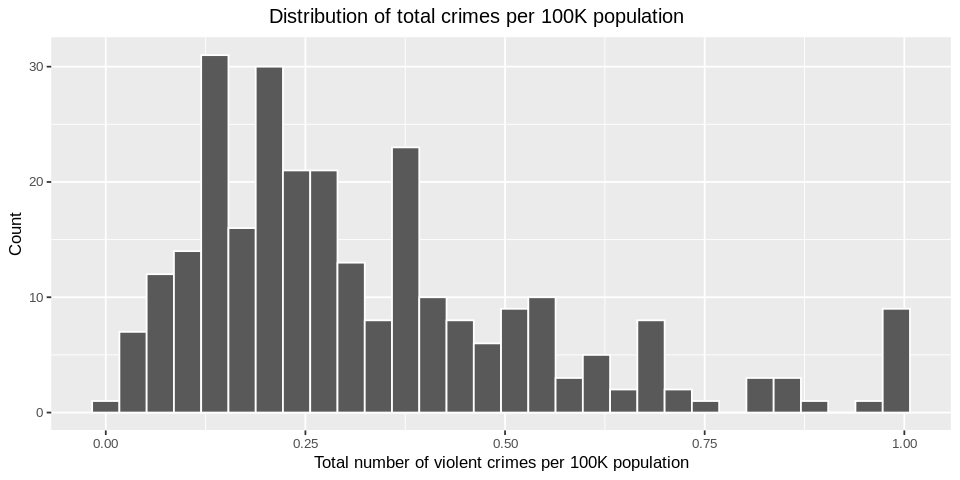

In [6]:
options(repr.plot.width = 8, repr.plot.height = 4)

tot_crime_dist <- clean_crime %>%
    ggplot(aes(x = totCrimesPerPop)) +
    geom_histogram(bins = 30, color = "white") +
    xlab("Total number of violent crimes per 100K population") +
    ylab("Count") +
    ggtitle("Distribution of total crimes per 100K population") +
    theme(text = element_text(size = 10)) +
    theme(plot.title = element_text(hjust = 0.45))
tot_crime_dist

*Figure 1.1 Distribution of total number of vioment crimes per 100K population*

**... [description of above histogram]**

Then, we want to explore visually how each input variable is associated with the response variable, and whether there's any association between the input variables. We use the plotting function `ggpairs()`, from the library `GGally`, to generate a pair plot of ALL the variables found in `clean_crime`. The `ggplot()` object’s name is `crime_pair_plots`.

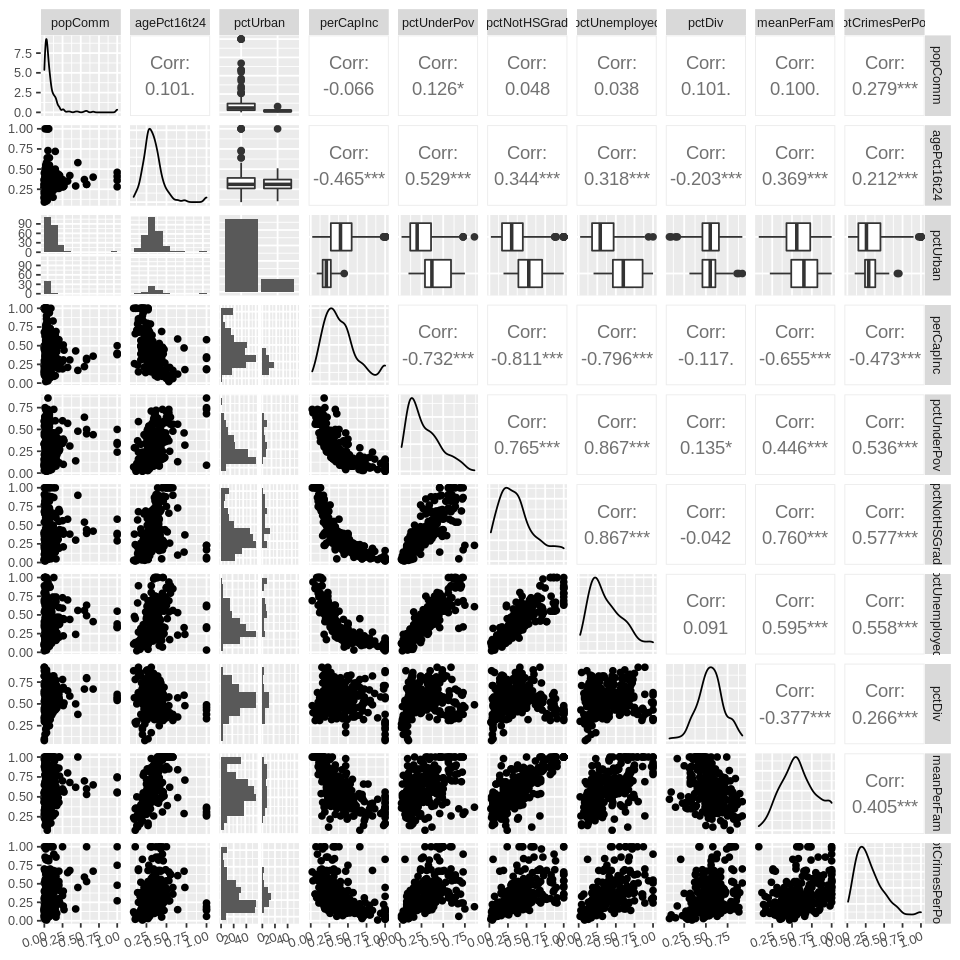

In [7]:
options(repr.plot.width = 8, repr.plot.height = 8)

crime_pair_plots <- clean_crime %>%
    ggpairs(progress = FALSE, lower=list(combo = wrap("facethist", binwidth = 0.1))) +
  theme(
    text = element_text(size = 9.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 20, hjust = 1)
)
crime_pair_plots

*Figure 1.2 Pair plots of all variables*

**...[description of above ggpairs]**

We want to use boxplot to clearly visualize the relationship between `pctUrban` and `totCrimesPerPop`. We use `geom_boxplot()` to visualize their relationship.

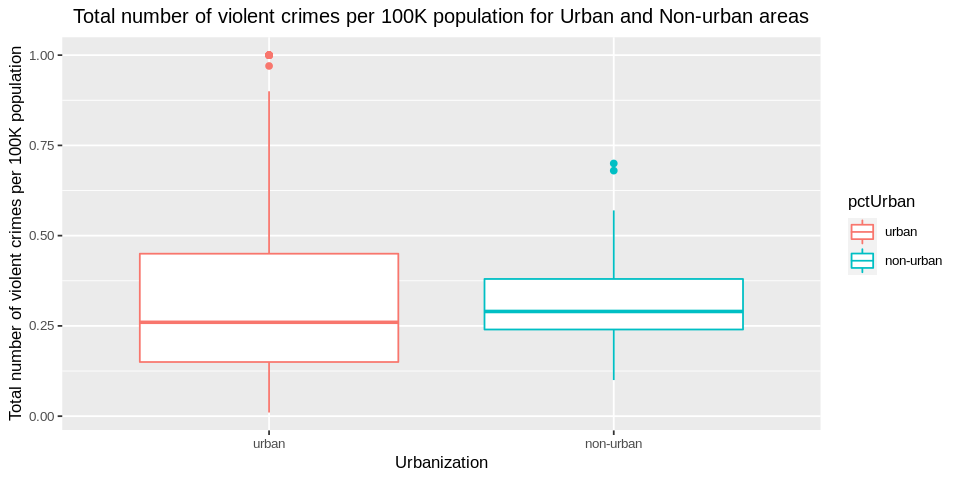

In [8]:
options(repr.plot.width = 8, repr.plot.height = 4)

urban_totCrime_boxplot <- 
    clean_crime %>%
    ggplot(aes(x = pctUrban, y = totCrimesPerPop , color = pctUrban)) +
    geom_boxplot() +
    xlab("Urbanization") +
    ylab("Total number of violent crimes per 100K population") +
    ggtitle("Total number of violent crimes per 100K population for Urban and Non-urban areas") +
    theme(text = element_text(size = 10)) +
    theme(plot.title = element_text(hjust = 0.5))

urban_totCrime_boxplot

*Figure 1.3 Boxplot of relationship between urbanization and total number of vioment crimes per 100K population*

**...[description of above boxplot]**

#### Statistics of Data

Next, we want to summarize the statistics of all of the continuous variables in our dataset and we call this summary table `crime_summary`.

In [9]:
crime_summary <-
    clean_crime %>%
    select(-pctUrban) %>%
    pivot_longer(cols = everything()) %>%
    group_by(name) %>% 
    summarise(
    mean = mean(value,na.rm = T),
    sd = sd(value,na.rm = T),
    median = median(value, na.rm = T),
    variance = var(value, na.rm = T),
    max = max(value, na.rm = T),
    min = min(value, na.rm = T))

crime_summary

name            mean       sd        median variance   max  min 
1 agePct16t24     0.33406475 0.1373223 0.310  0.01885743 1.00 0.09
2 meanPerFam      0.59312950 0.2219651 0.575  0.04926851 1.00 0.08
3 pctDiv          0.55500000 0.1502267 0.550  0.02256805 0.92 0.08
4 pctNotHSGrad    0.37967626 0.2516220 0.335  0.06331361 1.00 0.02
5 pctUnderPov     0.27661871 0.1807827 0.230  0.03268239 0.86 0.02
6 pctUnemployed   0.38611511 0.2341064 0.330  0.05480579 1.00 0.02
7 perCapInc       0.40586331 0.2344757 0.350  0.05497885 1.00 0.02
8 popComm         0.08992806 0.1442471 0.050  0.02080722 1.00 0.00
9 totCrimesPerPop 0.33046763 0.2261883 0.265  0.05116115 1.00 0.01

*Table 1.5 Summary table of statistics of continuous variables*

**...[description of above summary table]**

Now, we have done the preliminary results. We will then start to analyze the data and select the predictive model. Before doing these, we need to do the model assuption checkings.

### Linear Regression Model Assumption Checkings

#### Check Heteroscedasticity Using Residuals-fitted Value Plot

To check heteroscedasticity, we first use `lm()` to estimate the regression parameters and assign the results to the object `crime_full_model`. 

Then we obtain the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals using `tidy()` and store the results in `crime_full_model_results`.

In [10]:
crime_full_model <- lm(totCrimesPerPop ~., data = clean_crime)
crime_full_model_results <- tidy(crime_full_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
crime_full_model_results

term              estimate std.error statistic p.value conf.low conf.high
1  (Intercept)       -0.49    0.13      -3.83     0.00    -0.74    -0.24    
2  popComm            0.26    0.07       3.66     0.00     0.12     0.40    
3  agePct16t24        0.10    0.11       0.98     0.33    -0.10     0.31    
4  pctUrbannon-urban -0.10    0.03      -3.05     0.00    -0.17    -0.04    
5  perCapInc          0.25    0.09       2.76     0.01     0.07     0.42    
6  pctUnderPov        0.07    0.14       0.47     0.64    -0.22     0.35    
7  pctNotHSGrad       0.34    0.10       3.31     0.00     0.14     0.55    
8  pctUnemployed      0.26    0.12       2.07     0.04     0.01     0.50    
9  pctDiv             0.54    0.09       6.04     0.00     0.36     0.72    
10 meanPerFam         0.21    0.09       2.25     0.03     0.03     0.39

*Table 1.6*

So far, we are not going to interpret the computed results yet since our purpose is to check its heteroscedasticity. To detect heteroscedasticity, we look at residuals-fitted value plot for diagnosis. We use `plot()` function to get the visualization.

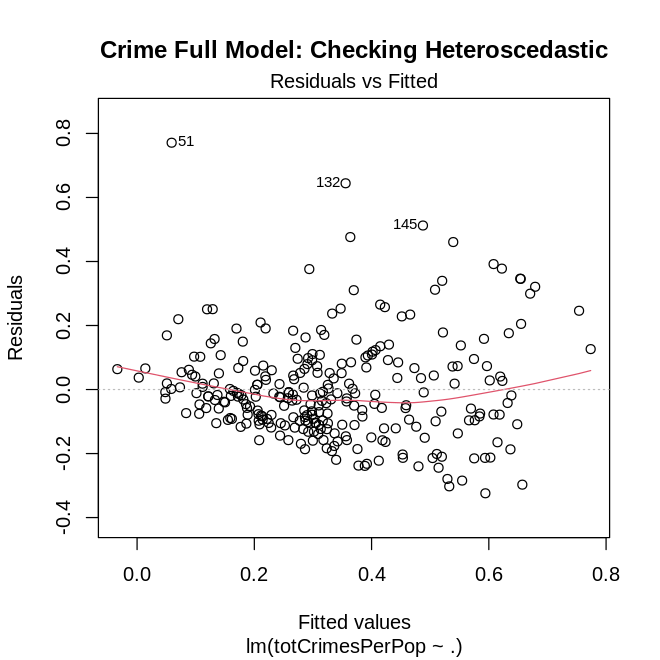

In [11]:
options(repr.plot.width = 5.5, repr.plot.height = 5.5)

plot(crime_full_model, 1, main = "Crime Full Model: Checking Heteroscedastic")

*Figure 1.4 Residuals-fitted Value Plot for checking heteroscedasticity*

According to  diagnosis rule, if the errors are homoscedastic (equal variance), the residuals should show equal variation for all fitted values. From the above residuals-fitted value plot, we observe that the diagnostic plot does not show a uniform and scattered cloud of points, which indicates a non-constant variance. It seems violate the rule and we want to remedy it. A common remedy is transformation of the response. Therefore, we use `log()` function to transform the original value of response to log value and we will repeat the above process again.

In [13]:
crime_full_OLS <- lm(log(totCrimesPerPop) ~., data = clean_crime)
crime_full_OLS_results <- tidy(crime_full_OLS, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
crime_full_OLS_results

term              estimate std.error statistic p.value conf.low conf.high
1  (Intercept)       -3.44    0.39      -8.73     0.00    -4.21    -2.66    
2  popComm            0.77    0.22       3.49     0.00     0.33     1.20    
3  agePct16t24        0.47    0.33       1.42     0.16    -0.18     1.11    
4  pctUrbannon-urban -0.17    0.10      -1.69     0.09    -0.37     0.03    
5  perCapInc         -0.19    0.28      -0.69     0.49    -0.74     0.35    
6  pctUnderPov       -0.09    0.45      -0.19     0.85    -0.97     0.80    
7  pctNotHSGrad       1.29    0.32       4.00     0.00     0.65     1.92    
8  pctUnemployed      0.24    0.39       0.63     0.53    -0.52     1.00    
9  pctDiv             2.03    0.28       7.31     0.00     1.48     2.57    
10 meanPerFam         0.47    0.29       1.64     0.10    -0.10     1.04

*Table 1.7*

We use `plot()` function to visualize the residuals-fitted value plot again for diagnosis.

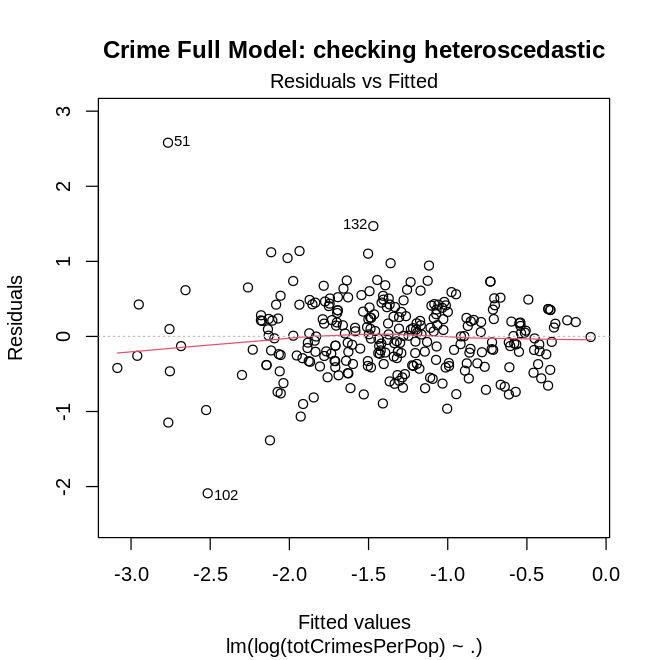

In [16]:
options(repr.plot.width = 5.5, repr.plot.height = 5.5)

plot(crime_full_OLS, 1, main = "Crime Full Model: checking heteroscedastic")

*Figure 1.5 Residuals-fitted Value Plot after transformation of the response* 

After we done the transformation of the response, the diagnostic plot of `crime_full_OLS` shows a uniform and more scattered cloud of points than `crime_full_model`, and the residuals show equal variation for almost all fitted values. Now, we have checked the errors are independent and identically distributed.

#### Check Normality using $Q$-$Q$ plots

In [15]:
# Check Normality
plot(full_model, 2, main = "Full Model")

ERROR: Error in plot(full_model, 2, main = "Full Model"): object 'full_model' not found


*Figure 1.5*

In [ ]:
hist(residuals(object = full_model),
  breaks = 10,
  main = "Histogram of Residuals for Full Model",
  xlab = "Residuals"
)


*Figure 1.6*

In [ ]:
# Check Multicollinearity
corr_matrix_crime <- 
    clean_crime %>%
    select(- pctUrban) %>%
    cor() %>%
    as.data.frame() %>%
    rownames_to_column("var1") %>%
    pivot_longer(- var1, names_to = "var2", values_to = "corr")
head(corr_matrix_crime)

#!!! need more description// might need to drop those with high multicolinearity

In [ ]:
# get vif of variables
VIF_full_model <- vif(full_model)
round(VIF_full_model, 3)

In [ ]:
# plot vif
options(repr.plot.width = 7, repr.plot.height = 7)

plot_corr_matrix_crime <- corr_matrix_crime %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "Variable 1", y = "Variable 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 8, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 8, hjust = 1
    ),
    legend.title = element_text(size = 8, face = "bold"),
    legend.text = element_text(size = 8),
    legend.key.size = unit(1, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 3.8)
plot_corr_matrix_crime

### Split the data into training set and testing set

In [ ]:
set.seed(301)

clean_crime$ID <- 1:nrow(clean_crime)
training_crime <- sample_n(clean_crime, size = nrow(clean_crime) * 0.60,
  replace = FALSE
)

testing_crime <- anti_join(clean_crime,
  training_crime,
  by = "totCrimesPerPop"
)

# removing the totCrimesPerPop variable

training_crime <- training_crime %>% select(-"totCrimesPerPop")
testing_crime <- testing_crime %>% select(-"totCrimesPerPop")

### For Prediction Model

### Model Selection

### Model Evaluation

## Reference

**References**

Daigle, Leah E.; Hancock, Katelyn; Chafin, Travis C.; Azimi, Andia. (2021). U.S. and Canadian College Students’ Fear of Crime: A Comparative Investigation of Fear of Crime and Its Correlates. *Journal of Interpersonal Violence 37(15-16).* https://doi.org/10.1177/08862605211001477 

 
National Research Council. (2008). *Understanding Crime Trends: Workshop Report.* Washington, DC: The National Academies Press. https://doi.org/10.17226/12472 


Federal Bureau of Investigation: Uniform Crime Report. (December, 2012). *Variables Affecting Crime.* Hate Crime Statistics. https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime
 

**Reference for Dataset**
 
Michael Redmond. (2009). *Communities and Crime Data Set.* UCI Machine Learning Repository Irvine, CA: the University of California, School of Information and Computer Science. https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime
